In [3]:
!pwd

/panda/eedy/ion_los-angle/stitch_s1_a


In [10]:
import datetime as dt
import os
import warnings

import h5py
import matplotlib as mpl
import numpy as np
from matplotlib import dates as mdates, pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from scipy.stats import gaussian_kde

from mintpy.objects import TIMESERIES_DSET_NAMES, TIMESERIES_KEY_NAMES
from mintpy.objects.colors import ColormapExt
from mintpy.objects.coord import coordinate
from mintpy.utils import network as pnet, ptime, readfile, utils0 as ut0
from mintpy.utils.map import draw_lalo_label, draw_scalebar
from matplotlib.ticker import MultipleLocator

def plot_insar_vs_gnss_scatter(vel_file, csv_file='gnss_enu2los_UNR.csv', msk_file=None, ref_gnss_site=None,
                               cutoff=5, fig_size=(4, 4), xname='InSAR', vlim=None, ex_gnss_sites=None,
                               display=True):

    disp_unit = 'cm/yr'
    unit_fac = 100.

    # read GNSS velocity from CSV file (generated by gnss.get_los_obs())
    col_names = ['Site', 'Lon', 'Lat', 'Displacement', 'Velocity']
    num_col = len(col_names)
    col_types = ['U10'] + ['f8'] * (num_col - 1)

    print(f'read GNSS velocity from file: {csv_file:s}')
    fc = np.genfromtxt(csv_file, dtype=col_types, delimiter=',', names=True)
    sites = fc['Site']
    lats = fc['Lat']
    lons = fc['Lon']
    gnss_obs = fc[col_names[-1]] * unit_fac

    if ex_gnss_sites is not None:
        ex_flag = np.array([site in ex_gnss_sites for site in sites], dtype=np.bool_)
        if np.sum(ex_flag) > 0:
            sites = sites[~ex_flag]
            lats = lats[~ex_flag]
            lons = lons[~ex_flag]
            gnss_obs = gnss_obs[~ex_flag]

    # read InSAR velocity
    print(f'read InSAR velocity from file: {vel_file:s}')
    atr = readfile.read_attribute(vel_file)
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    ys, xs = coordinate(atr).geo2radar(lats, lons)[:2]

    msk = readfile.read(msk_file)[0] if msk_file else np.ones((length, width), dtype=np.bool_)

    num_site = sites.size
    insar_obs = np.zeros(num_site, dtype=np.float32) * np.nan
    prog_bar = ptime.progressBar(maxValue=num_site)
    for i in range(num_site):
        x, y = xs[i], ys[i]
        if (0 <= x < width) and (0 <= y < length) and msk[y, x]:
            box = (x, y, x+1, y+1)
            insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac
        prog_bar.update(i+1, suffix=f'{i+1}/{num_site} {sites[i]}')
    prog_bar.close()

    off_med = np.nanmedian(insar_obs - gnss_obs)
    print(f'median offset between InSAR and GNSS [before common referencing]: {off_med:.2f} cm/year')

    # reference site
    if ref_gnss_site:
        print(f'referencing both InSAR and GNSS data to site: {ref_gnss_site}')
        ref_ind = sites.tolist().index(ref_gnss_site)
        gnss_obs -= gnss_obs[ref_ind]
        insar_obs -= insar_obs[ref_ind]

    # remove NaN value
    print(f'removing sites with NaN values in GNSS or {xname}')
    flag = np.multiply(~np.isnan(insar_obs), ~np.isnan(gnss_obs))
    if vlim is not None:
        print(f'pruning sites with value range: {vlim} {disp_unit}')
        flag *= gnss_obs >= vlim[0]
        flag *= gnss_obs <= vlim[1]
        flag *= insar_obs >= vlim[0]
        flag *= insar_obs <= vlim[1]

    gnss_obs = gnss_obs[flag]
    insar_obs = insar_obs[flag]
    sites = sites[flag]

    # stats
    print(f'GNSS   min/max: {np.nanmin(gnss_obs):.2f} / {np.nanmax(gnss_obs):.2f}')
    print(f'InSAR min/max: {np.nanmin(insar_obs):.2f} / {np.nanmax(insar_obs):.2f}')

    rmse = np.sqrt(np.sum((insar_obs - gnss_obs)**2) / (gnss_obs.size - 1))
    r2 = stats.linregress(insar_obs, gnss_obs)[2]
    print(f'RMSE = {rmse:.2f} {disp_unit}')
    print(f'R^2 = {r2:.2f}')

    # preliminary outlier detection
    diff_mad = ut0.median_abs_deviation(abs(insar_obs - gnss_obs), center=0)
    print(f'Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev ({diff_mad:.2f}) * {cutoff}')
    print('Site:  InSAR  GNSS')
    for site_name, insar_val, gnss_val in zip(sites, insar_obs, gnss_obs):
        if abs(insar_val - gnss_val) > diff_mad * cutoff:
            print(f'{site_name:s}: {insar_val:5.1f}, {gnss_val:5.1f}  {disp_unit}')

    # plot
    if display:
        plt.rcParams.update({'font.size': 14})
        if vlim is None:
            vlim = [np.min(insar_obs), np.max(insar_obs)]
            vbuffer = (vlim[1] - vlim[0]) * 0.2
            vlim = [vlim[0] - vbuffer, vlim[1] + vbuffer]

        fig, ax = plt.subplots(figsize=fig_size)

        # 绘制虚线
        ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')

        # 计算数据点的密度
        xy = np.vstack([insar_obs, gnss_obs])
        z = gaussian_kde(xy)(xy)

        # 绘制热力图散点图
        sc = ax.scatter(insar_obs, gnss_obs, c=z, s=3, cmap='viridis',vmin=0, vmax=1.5)

        # 添加颜色条
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(sc, cax=cax, label='Density')

        # 设置坐标轴范围
        ax.set_xlim(vlim)
        ax.set_ylim(vlim)

        # 设置坐标轴标签
        ax.set_xlabel(f'{xname} [mm/yr]')
        ax.set_ylabel(f'GNSS [mm/yr]')

        # 设置坐标轴比例相等
        ax.set_aspect('equal', 'box')

        # 将坐标轴刻度线朝向图内
        ax.tick_params(direction='in')
        # 将坐标轴刻度线朝向图内，同时隐藏纵坐标刻度标签
        #ax.tick_params(direction='in', axis='y', which='both', labelleft=False, labelright=False)

        # 在图像右下角添加文本
        # 获取坐标轴的范围
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # 计算右下角的坐标
        x_pos = xlim[1]
        y_pos = ylim[0]
        # 定义一个上移的偏移量
        offset = 0.03 * (ylim[1] - ylim[0])
        # 添加第一行文本并上移
        ax.text(x_pos - offset, y_pos + 3 * offset, f'$R^2={r2:.2f}$', horizontalalignment='right', verticalalignment='bottom')
        # 添加第二行文本并上移，保持与第一行右对齐
        ax.text(x_pos - offset, y_pos + offset - 0.02 * (ylim[1] - ylim[0]), f'RMSE={rmse*10:.1f} mm/yr', horizontalalignment='right', verticalalignment='bottom')

        # 调整布局
        fig.tight_layout()

        # 保存图像为 PDF 格式，背景透明度为 True，分辨率为 600 dpi
        out_fig = f'{vel_file}insar_vs_gnss.pdf'
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
        print('保存图像到文件', out_fig)

        # 显示图像
        plt.show()

    return sites, insar_obs, gnss_obs

read GNSS velocity from file: mintpy_no_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_no_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   47s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.17 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.33 / 1.22
RMSE = 0.38 cm/yr
R^2 = 0.81
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.38) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_no_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


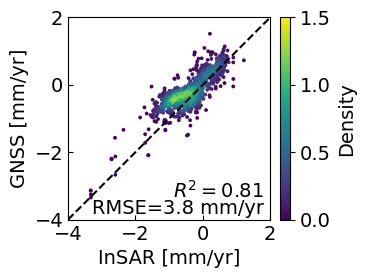

In [11]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_no_ion_upsample/gnss_enu2los_UNR.csv' , fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_no_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_gim_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_gim_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   36s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.09 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.26 / 1.49
RMSE = 0.30 cm/yr
R^2 = 0.82
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.27) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_gim_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


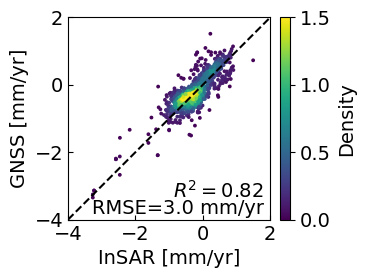

In [12]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_gim_ion_upsample/gnss_enu2los_UNR.csv', fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_gim_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_hight_gim_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_hight_gim_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   30s /     0s 
median offset between InSAR and GNSS [before common referencing]: -0.91 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.27 / 1.41
RMSE = 0.30 cm/yr
R^2 = 0.82
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.28) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_hight_gim_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


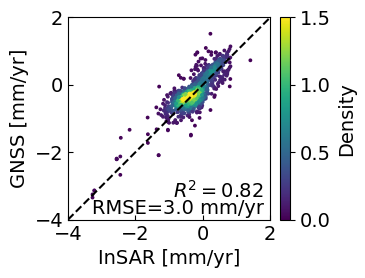

In [13]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_hight_gim_ion_upsample/gnss_enu2los_UNR.csv' , fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_hight_gim_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_split_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_split_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   31s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.42 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.27 / 1.35
RMSE = 0.28 cm/yr
R^2 = 0.87
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.26) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_split_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


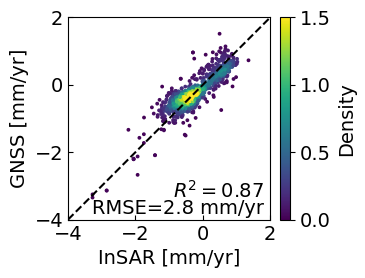

In [14]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_split_ion_upsample/gnss_enu2los_UNR.csv', fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_split_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_cas_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_cas_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   35s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.07 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.25 / 1.36
RMSE = 0.30 cm/yr
R^2 = 0.82
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.26) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_cas_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


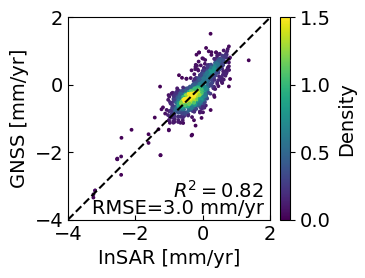

In [15]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_cas_ion_upsample/gnss_enu2los_UNR.csv' , fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_cas_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_MIT_gim_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_MIT_gim_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   31s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.15 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
pruning sites with value range: [-4, 2] cm/yr
GNSS   min/max: -3.35 / 1.51
InSAR min/max: -3.33 / 1.38
RMSE = 0.37 cm/yr
R^2 = 0.82
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.37) * 5
Site:  InSAR  GNSS


/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_MIT_gim_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


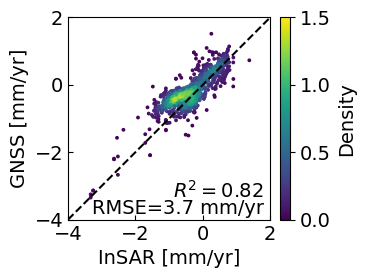

In [16]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_MIT_gim_ion_upsample/gnss_enu2los_UNR.csv' , fig_size = (4,4) , vlim=[-4, 2] )
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_MIT_gim_ion_upsample/geo_velocity.h5', **kwargs)

read GNSS velocity from file: mintpy_split_without-select_ion_upsample/gnss_enu2los_UNR.csv
read InSAR velocity from file: mintpy_split_without-select_ion_upsample/geo_velocity.h5
[>                                                 ]

/tmp/ipykernel_111367/1171749753.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  insar_obs[i] = readfile.read(vel_file, datasetName='velocity', box=box)[0] * unit_fac


[==================================================] 1278/1278 ZUMA   27s /     0s 
median offset between InSAR and GNSS [before common referencing]: -1.20 cm/year
referencing both InSAR and GNSS data to site: P606
removing sites with NaN values in GNSS or InSAR
GNSS   min/max: -6.65 / 5.62
InSAR min/max: -10.39 / 24.81
RMSE = 4.02 cm/yr
R^2 = -0.01
Preliminary outliers detection: abs(InSAR - GNSS) > med abs dev (0.72) * 5
Site:  InSAR  GNSS
ARM1:  -7.9,  -3.1  cm/yr
ARM2:  -7.9,  -3.1  cm/yr
BAK1:  -6.4,  -1.1  cm/yr
BFLD:  -6.4,  -0.8  cm/yr
CABK:  -6.3,  -0.7  cm/yr
CAD1:  -8.7,  -2.1  cm/yr
CAL8:  -4.3,   0.1  cm/yr
CAWO:  -5.4,  -0.1  cm/yr
CAWV:  -3.8,   1.1  cm/yr
DLNO:  -8.7,  -2.7  cm/yr
DONO:  -5.4,  -0.4  cm/yr
EDPP:  -4.2,   0.0  cm/yr
FMTP:  -3.9,   0.3  cm/yr
FMVT:  -4.5,   0.2  cm/yr
FZHS:  -4.4,   0.2  cm/yr
HELB:  -5.1,  -0.4  cm/yr
HELP:  -5.1,  -0.1  cm/yr
KDCB:  -5.9,  -0.5  cm/yr
LJRN:  -4.3,   0.2  cm/yr
MPWD:  -4.1,   0.3  cm/yr
MRRY:  -4.1,   0.0  cm/yr
MUSB:  -

/tmp/ipykernel_111367/1171749753.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot((vlim[0], vlim[1]), (vlim[0], vlim[1]), 'k--', color='black')


保存图像到文件 mintpy_split_without-select_ion_upsample/geo_velocity.h5insar_vs_gnss.pdf


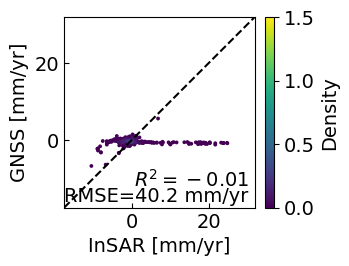

In [17]:
from mintpy.utils import readfile, utils as ut, plot as pp
kwargs = dict(ref_gnss_site='P606', csv_file='mintpy_split_without-select_ion_upsample/gnss_enu2los_UNR.csv' , fig_size = (4,4))
kwargs['ex_gnss_sites'] = ['BRAN','CAS4','CSN1','FCTF','IDQG','LBC2','LBCH','LBRF','LBSE','LBSW','LLAS','LMSG','LONG','MJPK','MLFP','MTA1','NOPK','P635','PEAR','SILK','TMAP','TRAK','VNCX','WHYT','SEMS','AZYW','IDQG','TMAP','CAEC']
sites, insar_obs, gnss_obs = plot_insar_vs_gnss_scatter(vel_file='mintpy_split_without-select_ion_upsample/geo_velocity.h5', **kwargs)